In [3]:
# Import required libraries
import os
import json
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Setup plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")


Libraries imported successfully!
Working directory: /Users/lukejohnson/ljStorage/projects/active/Capstone-UCSD/5-Data_Wrangling


In [7]:
# Define normalization functions (from combine_jsons.py and process_json.py)
html_fingerprint_entities = [
    {'char': "'", 'named': '&apos;', 'decimal': '&#39;', 'hex': '&#x27;'},
    {'char': '"', 'named': '&quot;', 'decimal': '&#34;', 'hex': '&#x22;'},
    {'char': '<', 'named': '&lt;', 'decimal': '&#60;', 'hex': '&#x3C;'},
    {'char': '>', 'named': '&gt;', 'decimal': '&#62;', 'hex': '&#x3E;'},
    {'char': '&', 'named': '&amp;', 'decimal': '&#38;', 'hex': '&#x26;'},
    {'char': '/', 'named': None, 'decimal': '&#47;', 'hex': '&#x2F;'},
    {'char': '(', 'named': None, 'decimal': '&#40;', 'hex': '&#x28;'},
    {'char': ')', 'named': None, 'decimal': '&#41;', 'hex': '&#x29;'},
]

unicode_escape_entities = [
    {'char': "'", 'unicode': '\\u0027'},
    {'char': '"', 'unicode': '\\u0022'},
    {'char': '<', 'unicode': '\\u003C'},
    {'char': '>', 'unicode': '\\u003E'},
    {'char': '&', 'unicode': '\\u0026'},
    {'char': '/', 'unicode': '\\u002F'},
    {'char': '(', 'unicode': '\\u0028'},
    {'char': ')', 'unicode': '\\u0029'},
]

# Build replacement map
replace_map = {}
for ent in html_fingerprint_entities:
    for key in ['named', 'decimal', 'hex']:
        if ent.get(key):
            replace_map[ent[key]] = ent['char']
for ent in unicode_escape_entities:
    replace_map[ent['unicode']] = ent['char']

def normalize_message(msg):
    """Normalize text by replacing HTML entities and Unicode escapes with regular characters."""
    if not isinstance(msg, str):
        return msg
    for k, v in replace_map.items():
        msg = msg.replace(k, v)
    return msg

def clean_user_message(user_message):
    """Extract text from user_message, handling different content types (from process_json.py)."""
    if isinstance(user_message, str):
        return user_message
    elif isinstance(user_message, dict):
        # Handle audio transcription
        if user_message.get("content_type") == "audio_transcription":
            return user_message.get("text", "")
        # Handle image asset pointer - no text content, skip
        elif user_message.get("content_type") == "image_asset_pointer":
            return ""
        # Handle real_time_user_audio_video_asset_pointer - no text content, skip
        elif user_message.get("content_type") == "real_time_user_audio_video_asset_pointer":
            return ""
        # For any other dict structure, try to find text field
        else:
            return user_message.get("text", "")
    else:
        return str(user_message)

print(f"Normalization functions defined!")
print(f"Replacement map contains {len(replace_map)} entities")
print("\nSample replacements:")
for i, (k, v) in enumerate(list(replace_map.items())[:5]):
    print(f"  {k} → {v}")


Normalization functions defined!
Replacement map contains 29 entities

Sample replacements:
  &apos; → '
  &#39; → '
  &#x27; → '
  &quot; → "
  &#34; → "


🔍 Step 1: Discovering data files...
Found 58 JSON files to process

File distribution by category:
  📁 green: 2 files
  📁 red: 3 files
  📁 yellow: 53 files


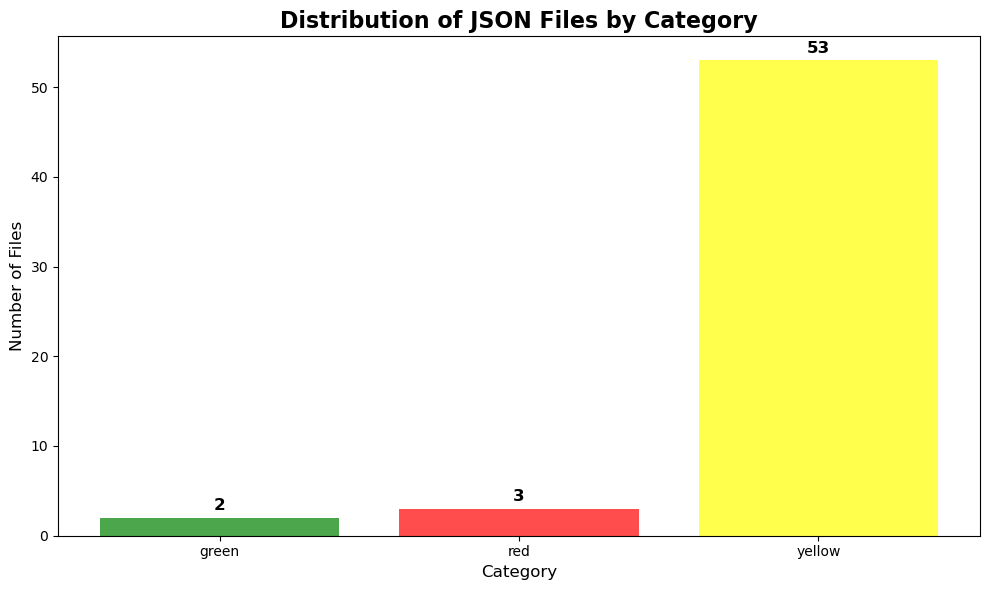

In [10]:
# Step 1: Discover and categorize data files
print("🔍 Step 1: Discovering data files...")

base_dir = os.getcwd()
json_files = [
    f for f in glob.glob(os.path.join(base_dir, '**', '*.json'), recursive=True)
    if os.path.basename(f) not in {'combined.json', '.DS_Store', 'combined_demo.json', 'combined_demo_notebook.json'}
]

print(f"Found {len(json_files)} JSON files to process")

# Categorize files by directory
file_categories = {}
for file_path in json_files:
    parent_dir = os.path.basename(os.path.dirname(file_path)).lower()
    if parent_dir not in file_categories:
        file_categories[parent_dir] = []
    file_categories[parent_dir].append(file_path)

print("\nFile distribution by category:")
for category, files in file_categories.items():
    print(f"  📁 {category}: {len(files)} files")

# Create visualization of file distribution
plt.figure(figsize=(10, 6))
categories = list(file_categories.keys())
file_counts = [len(file_categories[cat]) for cat in categories]
colors = ['green', 'red', 'yellow']

bars = plt.bar(categories, file_counts, color=colors[:len(categories)], alpha=0.7)
plt.title('Distribution of JSON Files by Category', fontsize=16, fontweight='bold')
plt.ylabel('Number of Files', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, file_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()
